In [12]:
import config
from forklens import train
from forklens.dataset import NNDataset
from torch.utils.data import DataLoader

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astropy.io import fits
import time

In [2]:
tr = train.NNTrain()
model_file = "./model/example_model99"
model = tr.load_model(path=model_file,strict=True)

In [8]:
# Get measured catalog
with fits.open('../cnn_tests/TypeI_dataset_5000case_2000real_-0.1-0.1shear.fits') as hdul:
    raw_data = hdul[0].data

Dataframe = {}
Dataframe['prediction'] = raw_data[:,1:5]
Dataframe['true_shear'] = raw_data[:,5] # g1
test_ds = NNDataset(Dataframe)

test_dl = DataLoader(test_ds, 
                      batch_size=2000, 
                      num_workers=8)
pred, true, loss = tr._predictFunc(test_dl,model)

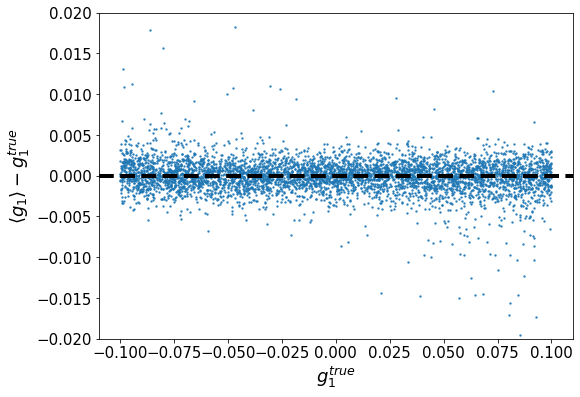

In [9]:
plt.figure(figsize=(8.5,6))

plt.scatter(true[:,1]*0.1,pred[:,1]*0.1-true[:,1]*0.1,s=2,alpha=0.8)
plt.axhline(0,color='k',linestyle='--',linewidth=4)

plt.ylim(-0.02,0.02)
plt.xlabel(r'$g^{true}_1$',fontsize=18)
plt.ylabel(r'$\left<g_1\right>-g^{true}_1$',fontsize=18)
plt.tick_params(axis='both',which='major',labelsize=15)

In [10]:
with fits.open('../cnn_tests/TypeII_dataset_100case_5000real_-0.1-0.1shear.fits') as f:
    cnn_pred = f[0].data
    
Shearframe = {}
Shearframe['prediction'] = cnn_pred[:,1:5]
Shearframe['true_shear'] = cnn_pred[:,5] # g1

test_ds = NNDataset(Shearframe)

test_dl = DataLoader(test_ds, 
                      batch_size=5000, 
                      num_workers=8)
pred, true, loss = tr._predictFunc(test_dl,model)

In [14]:
def linear_func(x,a,b):
    return x*a+b

popt,_ = curve_fit(linear_func,true[:,1]*0.1,pred[:,1]*0.1-true[:,1]*0.1)
print(popt)

[-4.36280577e-03 -5.61916935e-05]


Text(0.5, 1.0, 'NN calibration')

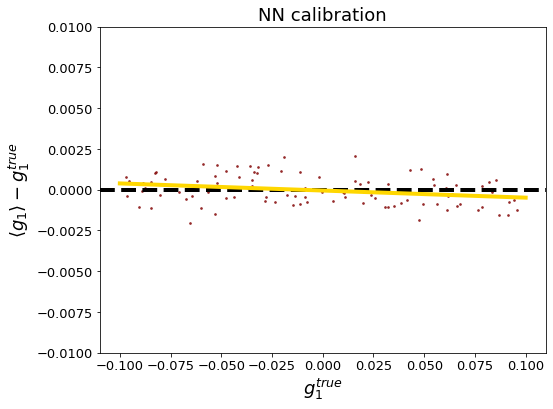

In [17]:
plt.figure(figsize=(8,6))

plt.scatter(true[:,1]*0.1,pred[:,1]*0.1-true[:,1]*0.1,s=3,color='maroon',alpha=0.7)

plt.axhline(0,color='k',linestyle='--',linewidth=4)
x = np.linspace(-0.1,0.1)
y = linear_func(x,popt[0],popt[1])
plt.plot(x,y,color='gold',linewidth=4,label=r'$10^3m=%.2f,10^4c=%.2f$'%(popt[0]/1e-3,popt[1]/1e-4))

plt.ylim(-0.01,0.01)
plt.tick_params(axis='both',which='major',labelsize=13)
plt.xlabel(r'$g^{true}_1$',fontsize=18)
plt.ylabel(r'$\left<g_1\right>-g^{true}_1$',fontsize=18)
plt.title('NN calibration', fontsize=18)